## Homework 3: Machine learning

In this assignment, we'll practice the classification skills from machine learning. We'll use the precinct-level voting data to predict support for Prop 21 (rent control) on the 2020 ballot. For example, we might expect the share of renters to be an important predictor.

We'll also review joins as we prepare the data.

Start by loading the 2020 elections results from LA County into a `pandas` dataframe, `voteDf`. (This is exactly the same data as we will use next week in the clustering lectures; I put another copy of the data file in the assignment GitHub folder to make things easier.)

### Policy on ChatGPT / AI

This is the same as in HWs 1 and 2. Please review those guidelines.

Please help me grade by observing the following:
 
* Do not rename this notebook (that messes up the autograder)
* Do not include large sections of output (that makes it hard to find your code). For example, use `df.head()` to show the first few rows, rather than printing an entire dataframe. The same goes for printing long strings.

In [2]:
import pandas as pd

voteDf = pd.read_csv('c037_g20_sov_data_by_g20_srprec.csv') # replace with your dataframe


print(len(voteDf))
print(voteDf.head())

4313
   county    srprec  addist  cddist  sddist  bedist  TOTREG  DEMREG  REPREG  \
0      19  0050005A      36      25      21       1    1974       0       0   
1      19  0050014A      36      25      21       1     697       0       0   
2      19  0050022A      36      27      25       1      61       0       0   
3      19  0050024A      41      27      25       1       0       0       0   
4      19  0050025A      36      25      25       1       5       0       0   

   AIPREG  ...  PR_23_Y  PR_24_N  PR_24_Y  PR_25_N  PR_25_Y  SENAIP01  \
0       0  ...      430      945      771     1304      398         0   
1       0  ...      100      314      223      427      116         0   
2       0  ...       10       27       22       35       15         0   
3       0  ...        0        0        0        0        0         0   
4       0  ...        1        2        3        1        3         0   

   SENDEM01  SENDEM02  SENLIB01  SENREP01  
0       524         0         0      

In [4]:
# Autograding tests - do not edit
assert len(voteDf) == 4313
assert isinstance(voteDf, pd.DataFrame)

To do some prediction, we'll want to add variables from (say) the census or other sources.
For that, we need the lookup file that matches precincts to census blocks and tracts. [You can find it here](https://statewidedatabase.org/d10/g20_geo_conv.html), or just use the file `c037_g20_sr_blk_map.csv` in your GitHub repository. (Note that there are several types of precincts; the ones that we are using here are called `srprec`.) 

Each precinct intersects with many census blocks. The `pctsrprec` column tells you how much of the precinct lies within that block. For example, in the first few rows of `c037_g20_sr_blk_map.csv`, you'll see 49 different rows for precinct `0050003A`, each matching to a different census block, with the `pctsrprec` column adding up to 100.

Our aim is to create a new dataframe with the vote counts (for all of the propositions and other races) aggregated to census tract. This is a multi-stage process, so let's do this step by step.

In this step, you should:
- load in the lookup data into a new dataframe, `lookupDf`
- join the voting dataframe to the lookup dataframe using `srprec`, to create a new dataframe called `joinDf`. This is a 1:many join, since there are many census blocks per precinct. Do an inner join, as the Null values are not going to be useful to us. (In other words, throw away any lookups that don't match a precinct.)
- make sure that `srprec` is the index

In [6]:
lookupDf = pd.read_csv('c037_g20_sr_blk_map.csv') 
lookupDf.set_index('srprec', inplace = True)
voteDf.set_index('srprec', inplace = True)
joinDf = voteDf.join(lookupDf, how='inner')



In [20]:
print(len(joinDf))
joinDf.iloc[0]

77703


1338.0

In [10]:
print(len(lookupDf))
print(len(joinDf))
print(joinDf.county.count())
print(joinDf.TOTREG.sum())
assert joinDf.index.name=='srprec'
assert len(lookupDf)==77704
assert len(joinDf)==77703
assert joinDf.county.count()==77703
assert joinDf.TOTREG.sum()==168427815

77704
77703
77703
168427815


Now let's calculate vote shares on Prop 21 and in the presidential race for each census tract. 

This is slightly tricky, because your data frame `joinDf` will have multiple rows per tract (because the precinct geography does not match the census geography). For example, the following code shows you which precincts intersect with tract 119342. 

13.65% of the first precinct listed, `9004204A`, is in tract 119342.

In [12]:
joinDf[joinDf.tract==119342][['tract','pctsrprec']].sort_index(ascending=False)

,tract,pctsrprec
srprec,,
9004204A,119342,13.653137
9000576A,119342,22.065955
9000576A,119342,25.412221
9000576A,119342,0.533463


So to aggregate to tracts, you should:
- for each relevant column, multiply the number of votes by `pctsrprec`, and divide by 100 (because `pctsrprec` is a percentage, not a fraction)
- group by census tract and sum those relevant columns, to create a new dataframe called `tractVotes`. It should have columns `PR_21_N`, `PR_21_Y`, `PRSDEM01`, `PRSREP01`, etc.

This will give us our estimate of votes at the tract level.

*Hint*: You can pass multiple columns to `groupby`. E.g. `df.groupby('groupcol')[['col1','col2','col3']].sum()`

In [32]:
joinDf['PR_21_N'] = (joinDf['PR_21_N']*joinDf['pctsrprec'])/100
joinDf['PR_21_Y'] = (joinDf['PR_21_Y']*joinDf['pctsrprec'])/100
joinDf['PRSDEM01'] = (joinDf['PRSDEM01']*joinDf['pctsrprec'])/100
joinDf['PRSREP01'] = (joinDf['PRSREP01']*joinDf['pctsrprec'])/100
tractVotes = joinDf.groupby('tract')[['PR_21_N','PR_21_Y','PRSDEM01','PRSREP01']].sum()
tractVotes.head()



,PR_21_N,PR_21_Y,PRSDEM01,PRSREP01
tract,,,,
101110,1024.227956,857.734445,1090.712262,895.321045
101122,1138.460030,747.218978,1057.143636,896.821118
101210,714.308221,849.445489,949.817716,723.604530
101220,761.014272,528.747773,747.489059,604.907175
101300,1218.104598,796.031104,1159.946654,948.800765


In [34]:
print(len(tractVotes))
print(tractVotes.PR_21_Y.sum())

# Autograding tests - do not edit
assert len(tractVotes)==2338
assert tractVotes.PR_21_Y.sum().round() == 2021487

2338
2021486.9997128805


Now let's get a dataframe of some relevant census variables, using the Census Bureau API. Check back to the Week 1 example and the first homework.

Create a dataframe, `censusDf`, with ACS 2019 (5 year) tract-level data for LA County, and variables for Tenure (B25003_001E, B25003_002E, B25003_003E) and median household income (B19013_001E). Add a column with the percent of renters, called `pct_renter`.

Rename the median HH income column `median_hh_income`, which is more meaningful.

Why use ACS 2019 rather than a more recent vintage? Well, the census tract boundaries change after each decennial census (i.e., in 2020), and the precinct-to-tract files we used above map to the pre-2020 census boundaries.

As a reminder, here's the Census API [list of tables](https://api.census.gov/data/2019/acs/acs5/variables.html), and [here are examples that you can adapt](https://api.census.gov/data/2019/acs/acs5/examples.html). 

*Hint:* Make sure to restrict your data request by state AND county if you want to keep it to a manageable size! You shouldn't need to request an API key for a small number of queries..

*Hint:* Look at your data if you get the wrong answer to median income! For example, use `censusDf.describe()`, or `censusDf.sort_values(by='med_hh_income').head()`. You might need to replace some values with `np.nan`.

In [103]:
import requests
import json
import numpy as np
r = requests.get('https://api.census.gov/data/2019/acs/acs5?get=NAME,B25003_001E,B25003_002E,B25003_003E,B19013_001E&for=tract:*&in=state:06&in=county:037')
censusdata = r.json()
censusDf = pd.DataFrame(censusdata[1:], columns=censusdata[0])
censusDf.head()


,NAME,B25003_001E,B25003_002E,B25003_003E,B19013_001E,state,county,tract
0,"Census Tract 4827.02, Los Angeles County, Cali...",802,579,223,82917,06,037,482702
1,"Census Tract 5002.01, Los Angeles County, Cali...",2209,1904,305,114831,06,037,500201
2,"Census Tract 5002.02, Los Angeles County, Cali...",1460,1293,167,133125,06,037,500202
3,"Census Tract 5003, Los Angeles County, California",1087,991,96,102875,06,037,500300
4,"Census Tract 5005, Los Angeles County, California",894,610,284,53500,06,037,500500


In [105]:
censusDf.rename(columns={'B19013_001E':'median_hh_income','B25003_001E':'tenure_total','B25003_002E':'owner_occ','B25003_003E':'renter_occ'}, inplace=True)
censusDf['tenure_total'] = censusDf['tenure_total'].astype('int64')
censusDf['renter_occ'] = censusDf['renter_occ'].astype('int64')
censusDf['median_hh_income'] = censusDf['median_hh_income'].astype('int64')
censusDf['pct_renter'] = (censusDf['renter_occ']/censusDf['tenure_total'])*100
censusDf.loc[censusDf['median_hh_income'] < 0, 'median_hh_income'] = np.nan

In [111]:
print (len(censusDf))
print (censusDf.pct_renter.mean())
print(censusDf.median_hh_income.mean())

# Autograding tests - do not edit
assert len(censusDf) == 2346
assert censusDf.pct_renter.mean().round() == 53
assert censusDf.median_hh_income.mean().round()==73243

2346
53.273758713248945
73242.84415584416


Create a new dataframe, `joinedDf`, with both your voting and census data, through a left join to the voting data. 

*Hint*: It will be easiest to join on the `tract` column (which is your index in `tractVotes`). Since everything is in LA County, you don't need to worry about the `state` or `county` fields.

*Hint*: You'll need to convert the `tract` column in `censusDf` to an integer first.

In [113]:
censusDf['tract'] = censusDf['tract'].astype('int64')
censusDf.set_index('tract', inplace=True)
joinedDf = tractVotes.join(censusDf)
joinedDf.head()


,PR_21_N,PR_21_Y,PRSDEM01,PRSREP01,NAME,tenure_total,owner_occ,renter_occ,median_hh_income,state,county,pct_renter
tract,,,,,,,,,,,,
101110,1024.227956,857.734445,1090.712262,895.321045,"Census Tract 1011.10, Los Angeles County, Cali...",1575.0,843,732.0,63534.0,06,037,46.476190
101122,1138.460030,747.218978,1057.143636,896.821118,"Census Tract 1011.22, Los Angeles County, Cali...",1312.0,1072,240.0,90389.0,06,037,18.292683
101210,714.308221,849.445489,949.817716,723.604530,"Census Tract 1012.10, Los Angeles County, Cali...",2297.0,401,1896.0,44083.0,06,037,82.542447
101220,761.014272,528.747773,747.489059,604.907175,"Census Tract 1012.20, Los Angeles County, Cali...",1357.0,535,822.0,43713.0,06,037,60.574797
101300,1218.104598,796.031104,1159.946654,948.800765,"Census Tract 1013, Los Angeles County, California",1445.0,1255,190.0,81776.0,06,037,13.148789


In [115]:
print(joinedDf.pct_renter.count())
print(joinedDf.pct_renter.mean())

# Autograding tests - do not edit
assert joinedDf.pct_renter.count() == 2318
assert joinedDf.pct_renter.mean().round() == 53

2318
53.28817335153003


Let's start with a simple random forests model with the following *x* variables:

* Median HH income
* Percent of HHs that are renters
* Presidential vote (2-party share of Democrat voters, i.e. the percent voting for Biden vs Trump, with other candidates ignored)

And the following *y* variable
* Whether Prop 21 won (received a majority) in that census tract. This should be `True` if the Yeses got more votes than the Nos.

(Yes, vote share in each tract would be better to predict rather than a binary variable - hold off on that for the challenge problem.)

Create the relevant columns, `pct_biden` and `PR_21_won`, in your `joinedDf` dataframe. 

Then split your dataframe into a training sample (75%) and a test sample (25%). *Hint*: Drop the `NaNs` first.

In [120]:
joinedDf['pct_biden'] = (joinedDf['PRSDEM01']/(joinedDf['PRSDEM01']+joinedDf['PRSREP01']))*100
joinedDf['PR_21_won'] = joinedDf['PR_21_Y'] > joinedDf['PR_21_N']
joinedDf.head()

,PR_21_N,PR_21_Y,PRSDEM01,PRSREP01,NAME,tenure_total,owner_occ,renter_occ,median_hh_income,state,county,pct_renter,pct_biden,PR_21_won
tract,,,,,,,,,,,,,,
101110,1024.227956,857.734445,1090.712262,895.321045,"Census Tract 1011.10, Los Angeles County, Cali...",1575.0,843,732.0,63534.0,06,037,46.476190,54.919132,False
101122,1138.460030,747.218978,1057.143636,896.821118,"Census Tract 1011.22, Los Angeles County, Cali...",1312.0,1072,240.0,90389.0,06,037,18.292683,54.102493,False
101210,714.308221,849.445489,949.817716,723.604530,"Census Tract 1012.10, Los Angeles County, Cali...",2297.0,401,1896.0,44083.0,06,037,82.542447,56.758999,True
101220,761.014272,528.747773,747.489059,604.907175,"Census Tract 1012.20, Los Angeles County, Cali...",1357.0,535,822.0,43713.0,06,037,60.574797,55.271454,False
101300,1218.104598,796.031104,1159.946654,948.800765,"Census Tract 1013, Los Angeles County, California",1445.0,1255,190.0,81776.0,06,037,13.148789,55.006429,False


In [128]:
from sklearn.model_selection import train_test_split

xvars = ['median_hh_income','pct_renter','pct_biden']
yvar = 'PR_21_won'
df_to_fit = joinedDf[xvars + [yvar]].dropna()
X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)



In [130]:
print(len(X_train))
print(len(X_test))
print(X_train.pct_biden.mean())
print(y_train.mean())

# Autograding tests - do not edit
assert len(X_train) == 1731
assert len(X_train.columns) == 3
assert len(X_test) == 578
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)
assert X_train.pct_biden.mean().round() == 74
assert y_train.mean().round(1) == 0.6


1731
578
73.99448083312072
0.5979202772963604


Estimate a random forests model, and assign the predicted *y* values from your *test* sample to `y_pred`.

In [134]:
from sklearn.ensemble import RandomForestClassifier 

rf = RandomForestClassifier(n_estimators = 100, random_state = 1)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('Predicted fraction True: {:.4f}. Actual fraction True: {:.4f}'.format(
    y_pred.mean(), y_test.mean()))


Predicted fraction True: 0.6332. Actual fraction True: 0.6142


In [136]:
print(len(y_pred))
print(y_pred.mean())

# Autograding tests - do not edit
assert len(y_pred)==len(y_test)
assert y_pred.mean().round(1) == 0.6

578
0.6332179930795848


Let's look at some measures of fit. Plot the confusion matrix.

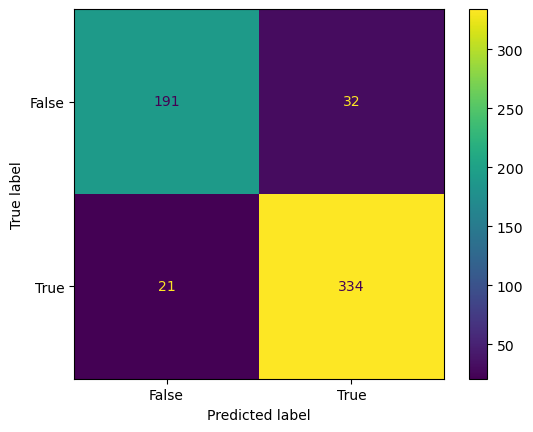

In [140]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)


Finally, plot the importance of each of the 3 predictor variables, in the same way as we did in class.

Text(0, 0.5, 'Mean decrease in impurity')

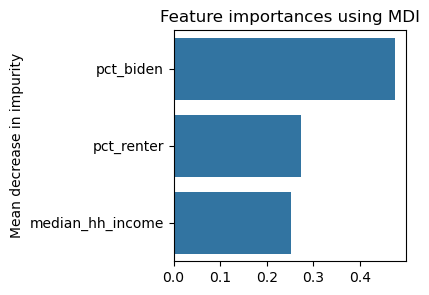

In [147]:
import seaborn as sns
import matplotlib.pyplot as plt
importances = rf.feature_importances_

forest_importances = pd.Series(importances, index=X_train.columns)

forest_importances.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(3,3))
sns.barplot(x=forest_importances.values[:3], y=forest_importances.index[:3], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")



Comment on your interpretation of the results and the confusion matrix. What do they tell you about:
- your predictive accuracy
- which variables are important
- how you might refine the model

The model’s predictive accuracy is quite strong, with 90.8% of precincts correctly classified in their support for Prop 21. The confusion matrix shows an overall balanced performance, with relatively few false positives and false negatives, indicating that the model is not heavily skewed toward one outcome.

Among the variables used, the percent that voted for Biden, percent renter, and median household income ranked as most important, in that order. While the feature importances don't indicate the direction of correlation, it’s interesting that political preference had more predictive power than renter status. This suggests that partisan alignment was more correlatedfor Prop 21 voting outcomes than direct housing tenure, which I did not expect given that Prop 21 would have direct material benefits for most (if not all) tenants.

To improve the model, we could incorporate more variables, experiment with alternative models like logistic regression or neural networks, or explore spatial clustering to identify geographic patterns in support for rent control.

# Challenge Problem
Remember, you need to do at least two of these challenge problems this quarter.

This challenge problem is open ended for you to take in a direction that you are most interested in. Here are some suggestions (do 1 or 2 of these):

* Extend the random forests model to predict vote share on Prop 21, rather than a binary yes/no, and using additional variables. See suggestions below. 
* Use a neural network instead. How much does this improve the predictions? Use charts to compare the predictions to the random forests model.
* Examine the geographic distribution of the predictions, through mapping the prediction errors. Where does your model perform best? Does this give you pointers as to how to improve your model?

In all cases, write some brief interpretation in a markdown cell.

*Predicting a continuous variable*

Classification problems are typically binary or categorical - which category do you predict a given observation to fall into. In some cases, however, we might want to predict a continuous variable, such as the percentage of "yes" votes on Prop 21. For this we can use `RandomForestRegressor`, which works very similarly to `RandomForestClassifier`. You can follow exactly the same steps: create the `rf` object, fit the model, and predict using the test sample.

How do you evaluate model performance? Since we have a continuous variable, we can't use the confusion matrix. But we can look at the absolute error (each predicted value minus the true value for each of our test precincts). I.e., `abs(y_pred-y_test)`. You can also do a scatter plot of the predicted values against the true values. The divergence from the 45 degree line is a good indication of how well the model fits.

In [154]:
# Create a new column in our dataframe that captures vote share, the percentage of people who voted Y on Prop 21 
joinedDf['pct_Prop_21_Y'] = (joinedDf['PR_21_Y']/(joinedDf['PR_21_Y']+joinedDf['PR_21_N']))*100
joinedDf.head()


,PR_21_N,PR_21_Y,PRSDEM01,PRSREP01,NAME,tenure_total,owner_occ,renter_occ,median_hh_income,state,county,pct_renter,pct_biden,PR_21_won,pct_Prop_21_Y
tract,,,,,,,,,,,,,,,
101110,1024.227956,857.734445,1090.712262,895.321045,"Census Tract 1011.10, Los Angeles County, Cali...",1575.0,843,732.0,63534.0,06,037,46.476190,54.919132,False,45.576598
101122,1138.460030,747.218978,1057.143636,896.821118,"Census Tract 1011.22, Los Angeles County, Cali...",1312.0,1072,240.0,90389.0,06,037,18.292683,54.102493,False,39.625990
101210,714.308221,849.445489,949.817716,723.604530,"Census Tract 1012.10, Los Angeles County, Cali...",2297.0,401,1896.0,44083.0,06,037,82.542447,56.758999,True,54.320926
101220,761.014272,528.747773,747.489059,604.907175,"Census Tract 1012.20, Los Angeles County, Cali...",1357.0,535,822.0,43713.0,06,037,60.574797,55.271454,False,40.995762
101300,1218.104598,796.031104,1159.946654,948.800765,"Census Tract 1013, Los Angeles County, California",1445.0,1255,190.0,81776.0,06,037,13.148789,55.006429,False,39.522218


In [261]:
# add variables to the dataframe
r = requests.get('https://api.census.gov/data/2019/acs/acs5?get=NAME,B02001_002E,B02001_003E,B02001_005E,B01001_002E,B01001_026E,B25003_002E&for=tract:*&in=state:06&in=county:037')
censusdata = r.json()
censusDf1 = pd.DataFrame(censusdata[1:], columns=censusdata[0])


In [281]:
censusDf1.rename(columns={'B02001_002E':'white','B02001_003E':'black','B02001_005E':'asian','B01001_002E':'male','B01001_026E':'female','B25003_002E':'owner'}, inplace=True)
censusDf1['white'] = censusDf1['white'].astype('int64')
censusDf1['black'] = censusDf1['black'].astype('int64')
censusDf1['asian'] = censusDf1['asian'].astype('int64')
censusDf1['male'] = censusDf1['male'].astype('int64')
censusDf1['female'] = censusDf1['female'].astype('int64')
censusDf1['owner'] = censusDf1['owner'].astype('int64')
censusDf1.head()

,NAME,white,black,asian,male,female,owner,state,county
tract,,,,,,,,,
482702,"Census Tract 4827.02, Los Angeles County, Cali...",689,27,1106,1009,1364,579,06,037
500201,"Census Tract 5002.01, Los Angeles County, Cali...",5592,29,549,3884,3383,1904,06,037
500202,"Census Tract 5002.02, Los Angeles County, Cali...",2961,33,1039,2406,2582,1293,06,037
500300,"Census Tract 5003, Los Angeles County, California",1906,26,481,1409,1564,991,06,037
500500,"Census Tract 5005, Los Angeles County, California",1435,23,226,1309,1394,610,06,037


In [317]:
# Setting tract as index for my new variables, I commented them out to stop getting errors when I reran the cell

# censusDf1['tract'] = censusDf1['tract'].astype('int64')
# censusDf1.set_index('tract', inplace=True)

In [319]:
# Dropping identical columns before the merge. Commented out to stop errors

# censusDf1 = censusDf1.drop(columns=['state','county','NAME'])
# joinedDf = joinedDf.join(censusDf1)

In [301]:
#Created a new column for pct_owner

joinedDf['pct_owner'] = (joinedDf['owner']/joinedDf['tenure_total'])*100
joinedDf.head()

,PR_21_N,PR_21_Y,PRSDEM01,PRSREP01,NAME,tenure_total,owner_occ,renter_occ,median_hh_income,state,...,pct_biden,PR_21_won,pct_Prop_21_Y,white,black,asian,male,female,owner,pct_owner
tract,,,,,,,,,,,,,,,,,,,,,
101110,1024.227956,857.734445,1090.712262,895.321045,"Census Tract 1011.10, Los Angeles County, Cali...",1575.0,843,732.0,63534.0,06,...,54.919132,False,45.576598,3347.0,19.0,331.0,2040.0,2243.0,843.0,53.523810
101122,1138.460030,747.218978,1057.143636,896.821118,"Census Tract 1011.22, Los Angeles County, Cali...",1312.0,1072,240.0,90389.0,06,...,54.102493,False,39.625990,2981.0,74.0,220.0,1626.0,1779.0,1072.0,81.707317
101210,714.308221,849.445489,949.817716,723.604530,"Census Tract 1012.10, Los Angeles County, Cali...",2297.0,401,1896.0,44083.0,06,...,56.758999,True,54.320926,4647.0,198.0,486.0,3350.0,2997.0,401.0,17.457553
101220,761.014272,528.747773,747.489059,604.907175,"Census Tract 1012.20, Los Angeles County, Cali...",1357.0,535,822.0,43713.0,06,...,55.271454,False,40.995762,2634.0,87.0,341.0,1717.0,1985.0,535.0,39.425203
101300,1218.104598,796.031104,1159.946654,948.800765,"Census Tract 1013, Los Angeles County, California",1445.0,1255,190.0,81776.0,06,...,55.006429,False,39.522218,3350.0,205.0,194.0,1897.0,1987.0,1255.0,86.851211


In [303]:
# Extending the random forest model to predict vote share on Prop 21 with added x variables

xvars = ['median_hh_income','pct_renter','pct_biden','white','black','asian','male','female','pct_owner']
yvar = 'pct_Prop_21_Y'
df_to_fit = joinedDf[xvars + [yvar]].dropna()
X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

rf = RandomForestRegressor(n_estimators = 100, random_state = 1)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))

Mean Absolute Error (MAE): 2.989995200448016


<Axes: xlabel='y_pred', ylabel='y_test'>

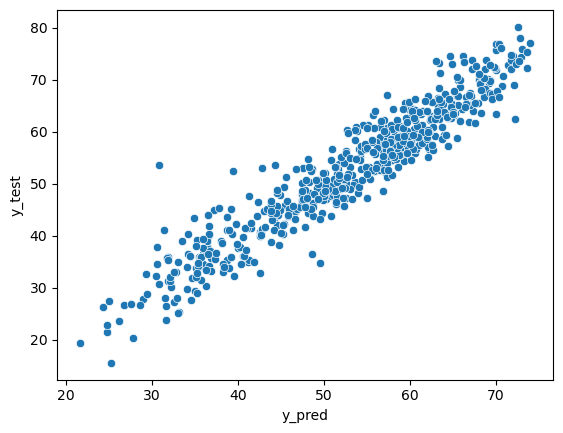

In [305]:
# Scatterplot of predicted vs true values
scatterdf = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test})

sns.scatterplot(data=scatterdf, x="y_pred", y="y_test")

Based on the Mean Absolute Error score of 2.98 (which I think means that we are 2 percentage points off between the predicted and test values) and the fact that our scatterplot follows a 45 degree angle pretty closely, the random forest model for the continuous y variable seems to fit pretty well. Next I'll try to use a neural network model, and see if there are any significant differences.

In [307]:
# Trying a neural network
# First standardize the data

from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(joinedDf[xvars])

df_scaled = pd.DataFrame(scaler.transform(joinedDf[xvars]), 
                         columns=xvars, index=joinedDf.index)

df_scaled = df_scaled.join(joinedDf.drop(columns=xvars))

df_scaled = df_scaled.dropna(subset=xvars)
df_scaled.head()

,median_hh_income,pct_renter,pct_biden,white,black,asian,male,female,pct_owner,PR_21_N,...,PRSREP01,NAME,tenure_total,owner_occ,renter_occ,state,county,PR_21_won,pct_Prop_21_Y,owner
tract,,,,,,,,,,,,,,,,,,,,,
101110,-0.280783,-0.259311,-1.685960,0.952248,-0.578251,-0.389306,-0.104520,0.069186,0.259311,1024.227956,...,895.321045,"Census Tract 1011.10, Los Angeles County, Cali...",1575.0,843,732.0,06,037,False,45.576598,843.0
101122,0.497620,-1.332167,-1.757765,0.646000,-0.482256,-0.533759,-0.625008,-0.497237,1.332167,1138.460030,...,896.821118,"Census Tract 1011.22, Los Angeles County, Cali...",1312.0,1072,240.0,06,037,False,39.625990,1072.0
101210,-0.844578,1.113617,-1.524186,2.040016,-0.265829,-0.187591,1.542437,0.989622,-1.113617,714.308221,...,723.604530,"Census Tract 1012.10, Los Angeles County, Cali...",2297.0,401,1896.0,06,037,True,54.320926,401.0
101220,-0.855303,0.277379,-1.654982,0.355649,-0.459566,-0.376292,-0.510601,-0.245765,-0.277379,761.014272,...,604.907175,"Census Tract 1012.20, Los Angeles County, Cali...",1357.0,535,822.0,06,037,False,40.995762,535.0
101300,0.247968,-1.527979,-1.678285,0.954758,-0.253612,-0.567595,-0.284302,-0.243323,1.527979,1218.104598,...,948.800765,"Census Tract 1013, Los Angeles County, California",1445.0,1255,190.0,06,037,False,39.522218,1255.0


In [309]:
# train/test split and run neural network, first on True/False y variable to see if it works
yvar = 'PR_21_won'

X_train, X_test, y_train, y_test = train_test_split(
      df_scaled[xvars], df_scaled[yvar], test_size = 0.25, random_state = 1)

from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

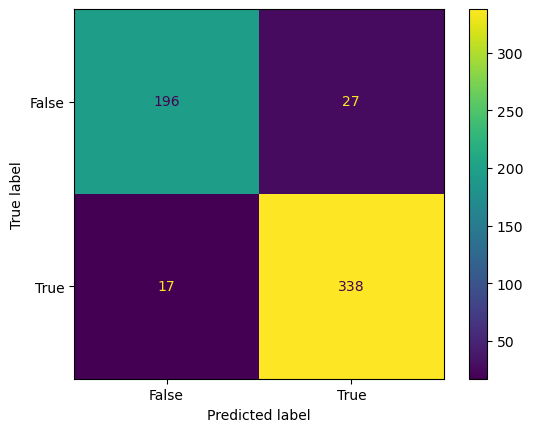

In [311]:
# print confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

The neural network seems to work for the binary y variable data (even a smidge better than the random forest model), so now I will try the neural network regressor for the continuous y variable. 

In [313]:
# now try neural network on the continuous y variable

yvar = 'pct_Prop_21_Y'

X_train, X_test, y_train, y_test = train_test_split(
      df_scaled[xvars], df_scaled[yvar], test_size = 0.25, random_state = 1)

from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))

Mean Absolute Error (MAE): 3.0983457781908204


<Axes: xlabel='y_pred', ylabel='y_test'>

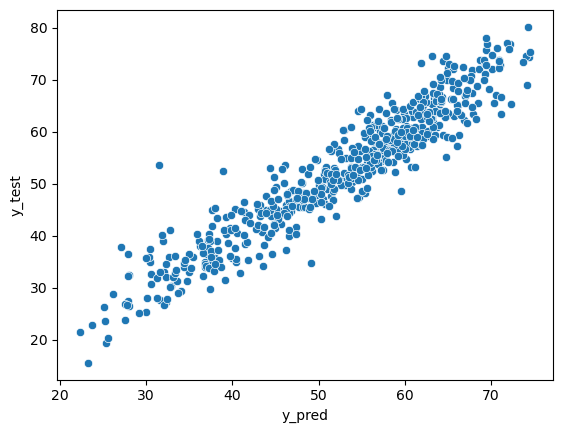

In [315]:
scatterdf = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test})

sns.scatterplot(data=scatterdf, x="y_pred", y="y_test")

The neural network model also seems to fit well for predicting whether voters in a tract voted yes on Prop 21! However, the mean absolute error value is just a hair higher, showing that the model does not fit as well as the random forest model, but the difference is quite slight. The scattersplot for the neural network model also indicates that the model fits well, as the data seems to follow a 45 degree angle. 